# IMDb Project

The aim of this project is to classify movies into three possible categories: Bad, Good or Great.

To obtain this classification, multivariated classification methods of ML will be used, starting by:
- Random Forest
- Multivariated Logistic Regression
- Multivariated Naive Bayes

The raw DB will be splitted into train (80%) and test (20%) subsets. 

Train subset will be further splitted into 5-folds to be submitted to cross-validation technique, in order to optimize the ML methods.

Folds will be evaluated by :  
- **Acuracy** (general evaluation)

- **Precision** (maximize True Positives)

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Montando a base de dados geral

In [2]:
# Importing fragments of the DB
'''
basics = pd.read_csv('../basics-data.tsv', sep='\t',low_memory=False)
ratings = pd.read_csv('../ratings-data.tsv', sep='\t',low_memory=False)
crew = pd.read_csv('/media/raissa/Seagate Expansion Drive/Datalab DB/crew-data.tsv', sep='\t',low_memory=False)
'''

# Merging data on a single DF
#db = pd.merge(pd.merge(basics, ratings, on="tconst"), crew, on ="tconst")

# Creating 1st backup archive
#db.to_csv('/media/raissa/Seagate Expansion Drive/Datalab DB/Joint-db.csv', index=False)


# Importing merged archive
db = pd.read_csv('../Joint-db-2.csv')
print('linhas:', db.shape[0])
print('colunas:', db.shape[1])

/home/raissa/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


linhas: 923856
colunas: 14


In [3]:
db.head()

,titleId,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers,translations
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.7,1879,nm0005690,\N,7
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",5.9,249,nm0721526,\N,7
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.5,1654,nm0721526,\N,8
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",5.8,162,nm0721526,\N,7
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",6.2,2479,nm0005690,\N,11


In [4]:
db.dtypes

titleId            object
titleType          object
primaryTitle       object
originalTitle      object
isAdult             int64
startYear          object
endYear            object
runtimeMinutes     object
genres             object
averageRating     float64
numVotes            int64
directors          object
writers            object
translations        int64
dtype: object

### Selecting movies of interest

As we are interested only in movie ratings, here we are filtering the DB for only 2 types of media:

- Movies
- tvMovies

<AxesSubplot:>

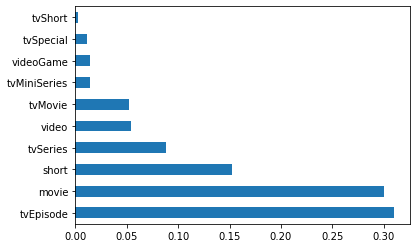

In [5]:
db['titleType'].value_counts(normalize=True).plot.barh()

In [6]:
movies1 = db[db['titleType']== 'movie']
movies2 = db[db['titleType']== 'tvMovie']
#movies3 = db[db['titleType']== 'short']
db_movies = pd.concat([movies1, movies2], ignore_index=True)

# Creating a second backup with only these media of interest

#db_movies.to_csv('../MoviesOnly.csv', index=False)

In [7]:
db_movies.head()

,titleId,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers,translations
0,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.5,14,nm0063413,"nm0063413,nm0657268,nm0675388",1
1,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",6.0,765,nm0846879,nm0846879,9
2,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,4.5,18,nm0141150,nm0141150,2
3,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama,4.5,23,nm0533958,"nm0092809,nm0533958",1
4,tt0000630,movie,Hamlet,Amleto,0,1908,\N,\N,Drama,3.8,24,nm0143333,nm0000636,4


According to the DB info, the endYear refers only to Series type of media, so let's drop this colum

In [8]:
db_movies.drop('endYear', inplace=True, axis=1)

### Null data

In this dataset, null data is registered under '\\N' sign. Let's change this to a NaN signature, which is easier to work with.

In [9]:
db_movies.replace(r'\\N', np.nan, regex=True, inplace=True)

Text(0.5, 1.0, 'Null percentage')

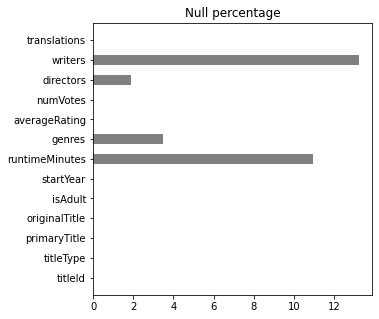

In [10]:
#db_movies.replace(r'\\N', np.nan, regex=True, inplace=True)

# Plot of null data
null = db_movies.isnull().sum()
percentage = null / db_movies.shape[0] * 100

width= 0.5
labels = null.index


plt.figure(figsize=(5,5))
plt.subplot()
plt.barh(labels, percentage, width, color='gray')
plt.title('Null percentage')

For now, let's drop the null values of directors and writers features. The other lines with null values will also be excluded in our first approach.

In [11]:
db_movies.dropna(axis=0, how='any', inplace=True)

# Confirming null data were removed
db_movies.isnull().sum()

titleId           0
titleType         0
primaryTitle      0
originalTitle     0
isAdult           0
startYear         0
runtimeMinutes    0
genres            0
averageRating     0
numVotes          0
directors         0
writers           0
translations      0
dtype: int64

### Directors and Writers count

- Count how much directors and writers each movie has
- Group them by most relevant values
- New feature: first movie or not

In [12]:
# Counting the amount of directors and fulfilling ['directorsCount'] new column
db_movies['directorsCount'] = db_movies.directors.apply(lambda x: len(x.split(",")))

# Counting the amount of writers and fulfilling ['writersCount'] new column
db_movies['writersCount'] = db_movies.writers.apply(lambda x: len(x.split(",")))

In [13]:
db_movies.head(2)

,titleId,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers,translations,directorsCount,writersCount
1,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,70,"Action,Adventure,Biography",6.0,765,nm0846879,nm0846879,9,1,1
2,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,90,Drama,4.5,18,nm0141150,nm0141150,2,1,1


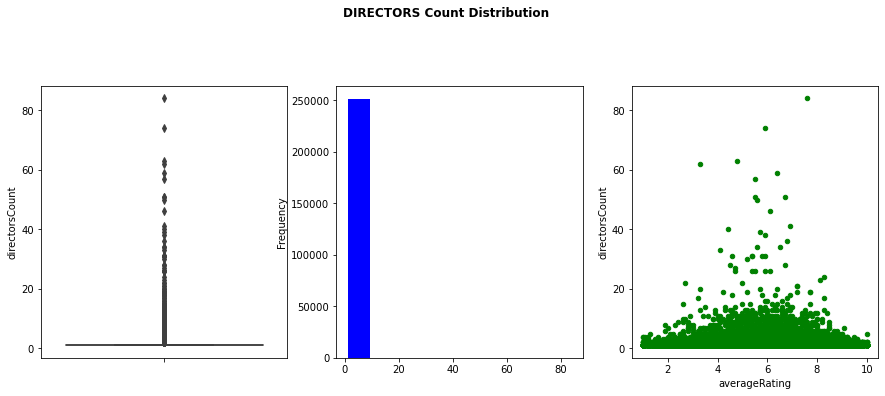

In [14]:
fig,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('DIRECTORS Count Distribution', y=1.1, weight='bold')

# Plot 1: boxplot distribution
ax1 = sns.boxplot(y='directorsCount', data=db_movies, orient='v', ax=ax1)
#ax1.set_title('Boxplot distribution of directors count')

# Plot 2: frequency distribution
ax2 = db_movies['directorsCount'].sort_values().plot.hist(ax=ax2, color='blue', bins=10)

# Plot 3: correlation between number of directors and average Rating
ax3 = db_movies.plot.scatter('averageRating','directorsCount', ax=ax3, color='green')

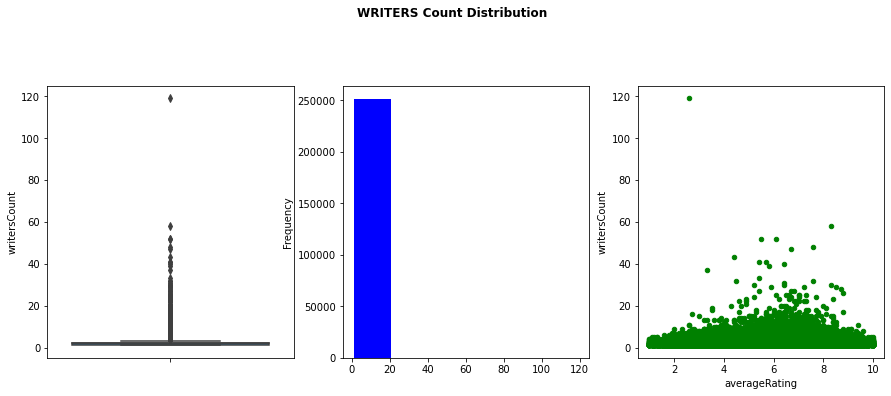

In [15]:
fig,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('WRITERS Count Distribution', y=1.1, weight='bold')

# Plot 1: boxplot distribution
ax1 = sns.boxplot(y='writersCount', data=db_movies, orient='v', ax=ax1)
#ax1.set_title('Boxplot distribution of directors count')

# Plot 2: frequency distribution
ax2 = db_movies['writersCount'].sort_values().plot.hist(ax=ax2, color='blue', bins=6)

# Plot 3: correlation between number of directors and average Rating
ax3 = db_movies.plot.scatter('averageRating','writersCount', ax=ax3, color='green')

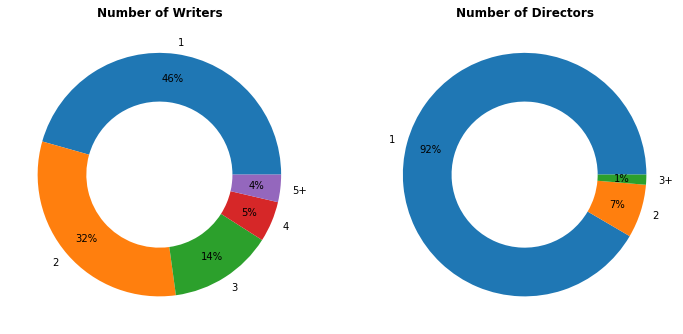

In [16]:
writer_counts = db_movies.writers.dropna().apply(lambda x: len(x.split(",")))
writer_counts[writer_counts>4] = "5+"

director_counts = db_movies.directors.dropna().apply(lambda x: len(x.split(",")))
director_counts[director_counts>2] = "3+"


plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
writer_counts.value_counts().plot.pie(autopct="%.0f%%",pctdistance=0.8, wedgeprops=dict(width=0.4))
plt.title("Number of Writers",fontweight="bold")
plt.ylabel(None)

plt.subplot(1,2,2)
director_counts.value_counts().plot.pie(autopct="%.0f%%",pctdistance=0.8, wedgeprops=dict(width=0.4))
plt.title("Number of Directors",fontweight="bold")
plt.ylabel(None)

plt.show()

In [17]:
# Grouping by the most common frequencies

db_movies['directorsCount'] = np.where(db_movies['directorsCount']>3, '3+', db_movies['directorsCount'])
db_movies['writersCount'] = np.where(db_movies['writersCount']>5, '5+', db_movies['writersCount'])

### Age classification

Text(0.5, 1.0, 'Adult percentage')

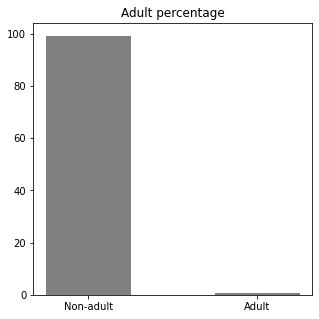

In [18]:
data = db_movies['isAdult'].value_counts()
percentage = [(x/db_movies.shape[0])*100 for x in data]

width= 0.5
labels = ['Non-adult', 'Adult']


plt.figure(figsize=(5,5))
plt.subplot()
plt.bar(labels, percentage, width, color='gray')
plt.title('Adult percentage')

As there is already a genre for Adult movies, we will remove this feature [IsAdult]

In [19]:
db_movies = db_movies.drop(columns=['isAdult'])
db_movies

,titleId,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers,translations,directorsCount,writersCount
1,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography",6.0,765,nm0846879,nm0846879,9,1,1
2,tt0000591,movie,The Prodigal Son,L'enfant prodigue,1907,90,Drama,4.5,18,nm0141150,nm0141150,2,1,1
6,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,1908,120,"Adventure,Fantasy",5.3,66,"nm0091767,nm0877783","nm0000875,nm0877783",2,2,2
23,tt0001184,movie,Don Juan de Serrallonga,Don Juan de Serrallonga,1910,58,"Adventure,Drama",3.9,20,"nm0550220,nm0063413",nm0049370,1,2,1
27,tt0001285,movie,The Life of Moses,The Life of Moses,1909,50,"Biography,Drama,Family",5.6,58,nm0085865,"nm0676645,nm0836316",7,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326012,tt9909424,tvMovie,Razreshite tebya potselovat... Otets nevesty,Razreshite tebya potselovat... Otets nevesty,2014,90,Comedy,4.6,6,nm5620850,"nm3576575,nm0606159",2,1,2
326013,tt9910984,tvMovie,Rivalen der Renaissance: Bellini und Mantegna,Rivalen der Renaissance: Bellini und Mantegna,2018,53,Documentary,7.4,8,nm5954264,nm5954264,3,1,1
326016,tt9913544,tvMovie,An American Named Kazan,Un Américain nommé Kazan,2018,53,"Biography,Documentary",7.1,20,nm1701148,nm1701148,3,1,1
326017,tt9915520,tvMovie,Fascism i en svart bil,Fascism i en svart bil,2019,55,"Documentary,History",6.9,7,nm8744716,"nm9513757,nm8744716",2,1,2


### Genres

Let's check the original distribution of genres in the dataset

<AxesSubplot:ylabel='genres'>

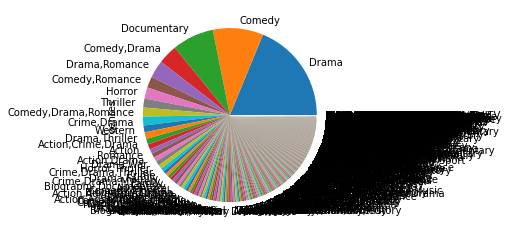

In [20]:
db_movies['genres'].value_counts().plot.pie()

There are movies that can belong to more than one genre, so we created a column with the summmation of possible genres of each movie (this will also be a future feature).

Also, to simplify our analysis, we extract only the 1st genre for usage. So each movie may have a main genre, but can also be 'ranked' by the ammount of genres it was once attributed

<AxesSubplot:>

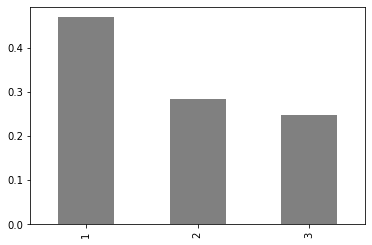

In [21]:
# Counting the genres and fulfilling ['genresCount'] new column
db_movies['genresCount'] = db_movies.genres.apply(lambda x: len(x.split(",")))

# Plotting movies according to the ammount of genres to which they belong
db_movies['genresCount'].value_counts(normalize=True).plot.bar(color='gray')

<AxesSubplot:>

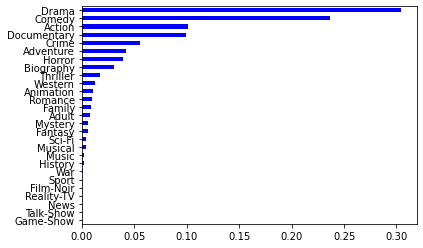

In [22]:
# Creating new column with the '1st genre only'
db_movies['1stGenre'] = db_movies.genres.apply(lambda x: x.split(",")[0])

# Plotting new genre distribution
db_movies['1stGenre'].value_counts(normalize=True).sort_values(ascending=True).plot.barh(color='blue')

In [23]:
db_movies['1stGenre'].value_counts()

Drama          76457
Comedy         59459
Action         25418
Documentary    24930
Crime          14025
Adventure      10677
Horror          9771
Biography       7627
Thriller        4263
Western         3169
Animation       2558
Romance         2449
Family          2181
Adult           2036
Mystery         1545
Fantasy         1350
Sci-Fi          1047
Musical         1046
Music            461
History          426
War              364
Sport             88
Film-Noir         35
Reality-TV        12
News               4
Talk-Show          3
Game-Show          2
Name: 1stGenre, dtype: int64

Choosing those genres with fewer occurencies to be grouped as 'Others' in order to simplify data

<AxesSubplot:>

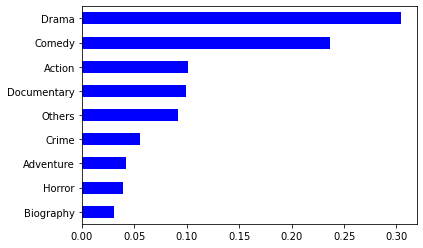

In [24]:
drop_genre = ['Thriller', 'Animation', 'Adult', 'Romance', 'Fantasy', 'Western', 'Family', 'Sci-Fi', 'Mystery', \
              'Music', 'Musical', 'History', 'War', 'Sport', 'News', 'Reality-TV', 'Film-Noir', 'Talk-Show', \
              'Game-Show']

db_movies['1stGenre'].replace(drop_genre, 'Others', inplace=True)

# New distribution

db_movies['1stGenre'].value_counts(normalize=True).sort_values(ascending=True).plot.barh(color='blue')

## Grouping Ratings

Group ranges for future classification task. Proposed classes are:

- Bad **(0)**: original rating bellow *1st quartile*
- Good **(1)**: original rating between *2nd and 3rd quartiles*
- Great **(2)**: original rating above *3rd quartile*

First, taking a look at the raw rating distribution:

In [25]:
db_movies['averageRating'].describe()

count    251403.000000
mean          6.121489
std           1.309576
min           1.000000
25%           5.300000
50%           6.200000
75%           7.000000
max          10.000000
Name: averageRating, dtype: float64

Median for raw Rating is: 6.2


Text(0.5, 1.0, 'Dispersion')

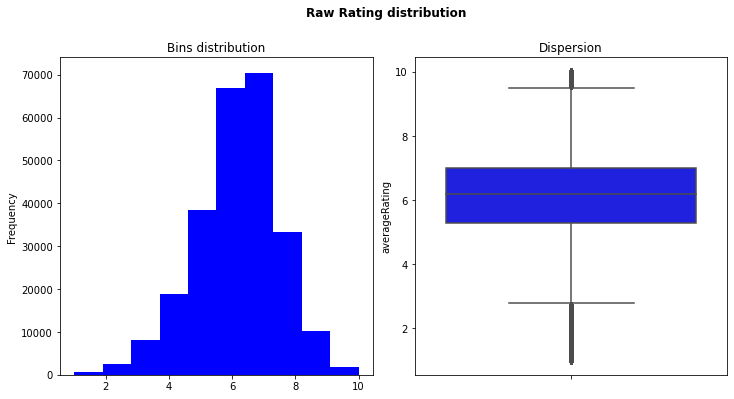

In [26]:
print('Median for raw Rating is:', db_movies['averageRating'].median())

fig1,(ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig1.tight_layout()
fig1.suptitle('Raw Rating distribution', y=1.1, weight='bold')

# Left: histogram
ax1 = db_movies['averageRating'].sort_values().plot.hist(ax=ax1, color='blue')
ax1.set_title('Bins distribution')

# Right: boxplot 
ax2 = sns.boxplot(y='averageRating', data=db_movies, orient='v', color='blue')
ax2.set_title('Dispersion')

Text(0.5, 1.0, '#votes by media type')

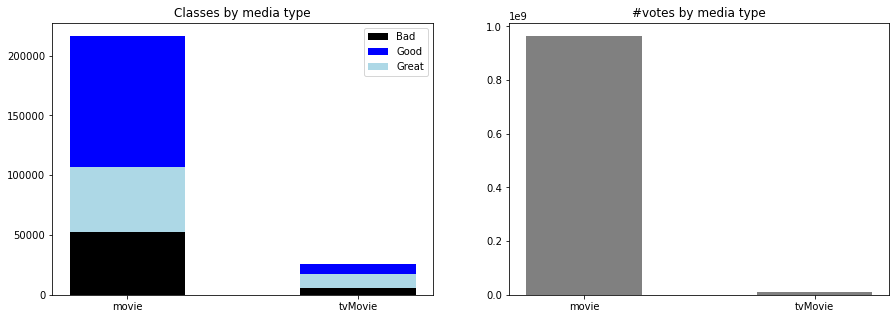

In [27]:
# Creating filter for each type of media and calculating quantity and vote number

#Movie
maskMovie = db_movies[db_movies['titleType']=='movie']

votesMovie = maskMovie['numVotes'].sum()
bad_movie = maskMovie[maskMovie['averageRating']<5.3].shape[0]
good_movie = maskMovie[maskMovie['averageRating']<7.0].shape[0]
great_movie = maskMovie[maskMovie['averageRating']>=7.0].shape[0]


#TVMovie
maskTVMovie = db_movies[db_movies['titleType']=='tvMovie']

votesTVMovie = maskTVMovie['numVotes'].sum()
bad_tvmovie = maskTVMovie[maskTVMovie['averageRating']<5.3].shape[0]
good_tvmovie = maskTVMovie[maskTVMovie['averageRating']<7.0].shape[0]
great_tvmovie = maskTVMovie[maskTVMovie['averageRating']>=7.0].shape[0]

# 

votes_list = [votesMovie, votesTVMovie]
bad_list = [bad_movie, bad_tvmovie]
good_list = [good_movie, good_tvmovie]
great_list = [great_movie, great_tvmovie]


# Plotting the mean rating for each class of media (left) and the ammount of votes (right)

fig1,(ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
width= 0.5
labels = ['movie', 'tvMovie']

ax1.bar(labels, bad_list, width, label='Bad', color='black')
ax1.bar(labels, good_list, width, bottom=bad_list, label='Good', color='blue')
ax1.bar(labels, great_list, width, bottom=bad_list, label='Great', color='lightblue')
ax1.set_title('Classes by media type')
ax1.legend()

ax2.bar(labels, votes_list, width, color='gray')
ax2.set_title('#votes by media type')

Thus, we can see that 'short' and 'tvMovie' categories both have higher ratings on the average, but 'movies' has a much higher quantity of votes!

Text(0.5, 1.0, 'TV Movie')

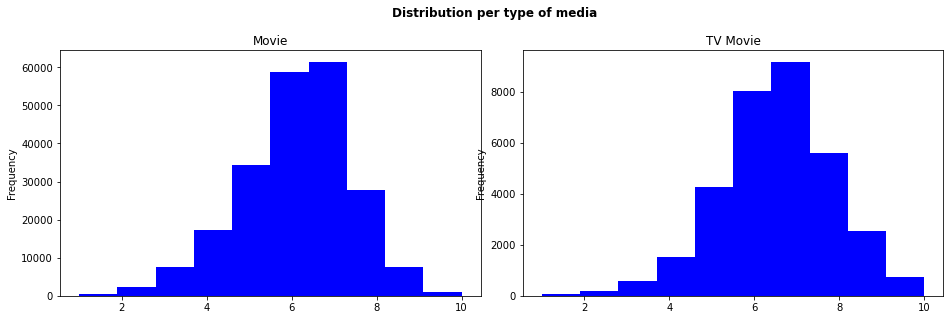

In [28]:
fig3, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
fig3.tight_layout()
fig3.suptitle('Distribution per type of media', y=1.1, weight='bold')


# Middle: Movie
ax1 = maskMovie['averageRating'].sort_values().plot.hist(ax=ax1, color='blue')
ax1.set_title('Movie')

# Right: tvMovie
ax2 = maskTVMovie['averageRating'].sort_values().plot.hist(ax=ax2, color='blue')
ax2.set_title('TV Movie')

Removing those initial outliers....

In [29]:
db_movies=db_movies[db_movies['averageRating']>2.7]

Median for NEW Rating is: 6.3


Text(0.5, 1.0, 'Dispersion')

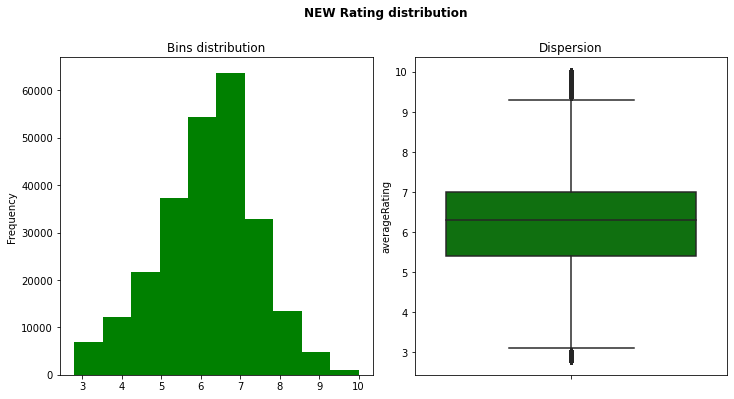

In [30]:
print('Median for NEW Rating is:', db_movies['averageRating'].median())

fig1,(ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig1.tight_layout()
fig1.suptitle('NEW Rating distribution', y=1.1, weight='bold')

# Left: histogram
ax1 = db_movies['averageRating'].sort_values().plot.hist(ax=ax1, color='green')
ax1.set_title('Bins distribution')

# Right: boxplot 
ax2 = sns.boxplot(y='averageRating', data=db_movies, orient='v', color='green')
ax2.set_title('Dispersion')

Text(0.5, 1.0, 'TV Movie')

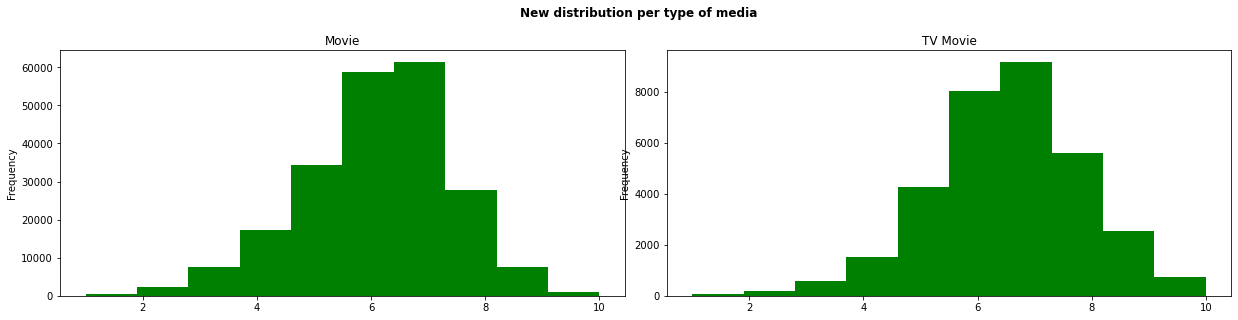

In [31]:
fig3, (ax1, ax2) = plt.subplots(1,2, figsize=(17,4))
fig3.tight_layout()
fig3.suptitle('New distribution per type of media', y=1.1, weight='bold')


# Middle: Movie
ax1 = maskMovie['averageRating'].sort_values().plot.hist(ax=ax1, color='green')
ax1.set_title('Movie')

# Right: tvMovie
ax2 = maskTVMovie['averageRating'].sort_values().plot.hist(ax=ax2, color='green')
ax2.set_title('TV Movie')

Text(0.5, 1.0, '#votes by media type')

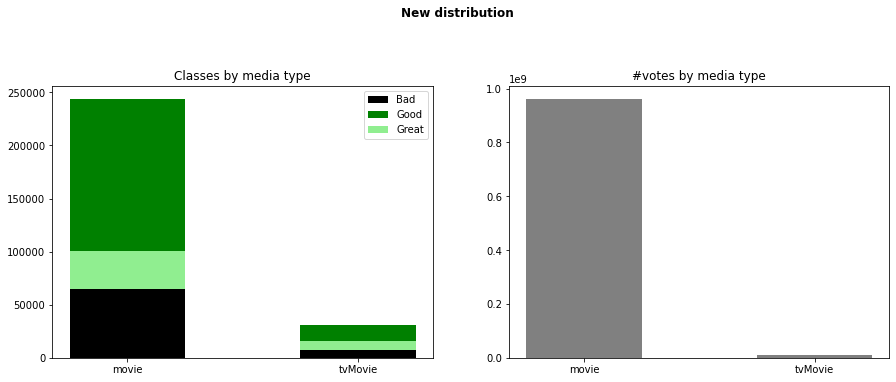

In [32]:
#Movie
maskMovie = db_movies[db_movies['titleType']=='movie']

votesMovie = maskMovie['numVotes'].sum()
bad_movie = maskMovie[maskMovie['averageRating']<5.6].shape[0]
good_movie = maskMovie[maskMovie['averageRating']<7.3].shape[0]
great_movie = maskMovie[maskMovie['averageRating']>=7.3].shape[0]


#TVMovie
maskTVMovie = db_movies[db_movies['titleType']=='tvMovie']

votesTVMovie = maskTVMovie['numVotes'].sum()
bad_tvmovie = maskTVMovie[maskTVMovie['averageRating']<5.6].shape[0]
good_tvmovie = maskTVMovie[maskTVMovie['averageRating']<7.3].shape[0]
great_tvmovie = maskTVMovie[maskTVMovie['averageRating']>=7.3].shape[0]

# 

votes_list = [votesMovie, votesTVMovie]
bad_list = [bad_movie, bad_tvmovie]
good_list = [good_movie, good_tvmovie]
great_list = [great_movie, great_tvmovie]


# Plotting the mean rating for each class of media (left) and the ammount of votes (right)

fig1,(ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
fig1.suptitle('New distribution', y=1.1, weight='bold')
width= 0.5
labels = ['movie', 'tvMovie']

ax1.bar(labels, bad_list, width, label='Bad', color='black')
ax1.bar(labels, good_list, width, bottom=bad_list, label='Good', color='green')
ax1.bar(labels, great_list, width, bottom=bad_list, label='Great', color='lightgreen')
ax1.set_title('Classes by media type')
ax1.legend()

ax2.bar(labels, votes_list, width, color='gray')
ax2.set_title('#votes by media type')

Creating the Quality Class:

In [33]:
# Creating the quality category
def RatingsCategory(df):
    
    df['RatingClass'] = np.where(df['RatingClass']<=5.6, 0, df['RatingClass'])
    df['RatingClass'] = np.where(( (df['RatingClass']>5.6) & (df['RatingClass']<7.3) ), 1, df['RatingClass'])
    df['RatingClass'] = np.where(df['RatingClass']>=7.3, 2, df['RatingClass'])
    
    return(df)

db_movies['RatingClass']=db_movies['averageRating']
db_movies = RatingsCategory(db_movies)

# Rounding rating values
db_movies['RatingClass']=db_movies.RatingClass.apply(lambda x: int(x))

<ipython-input-33-ea5087f4c4c4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_movies['RatingClass']=db_movies['averageRating']
<ipython-input-33-ea5087f4c4c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RatingClass'] = np.where(df['RatingClass']<=5.6, 0, df['RatingClass'])
<ipython-input-33-ea5087f4c4c4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

### Grouping classes of movies by length

Using **[runtimeMinute]** as source of information:

- Short **(0)**: runtime <= 15 min
- Medium **(1)**: 15 min > runtime <= 70 min
- Long **(2)**: runtime > 70 min

In [34]:
# Transforming values in int

db_movies['runtimeMinutes'] = [int(x) for x in db_movies['runtimeMinutes'].to_list()]


# Creating the lenght category

db_movies['lengthCategory'] = db_movies['runtimeMinutes']

def MovieCategory(df):
    
    df['lengthCategory'] = np.where(df['lengthCategory']<=15, 0, df['lengthCategory'])
    df['lengthCategory'] = np.where(( (df['lengthCategory']>15) & (df['lengthCategory']<=70) ), 1, df['lengthCategory'])
    df['lengthCategory'] = np.where(df['lengthCategory']>70, 2, df['lengthCategory'])
    
    return(df)

db_movies = MovieCategory(db_movies)

<ipython-input-34-569d38b1c876>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_movies['runtimeMinutes'] = [int(x) for x in db_movies['runtimeMinutes'].to_list()]
<ipython-input-34-569d38b1c876>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_movies['lengthCategory'] = db_movies['runtimeMinutes']
<ipython-input-34-569d38b1c876>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

Text(0, 0.5, 'Minutes')

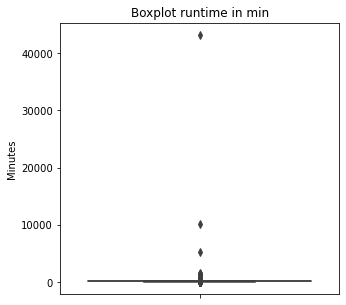

In [35]:
# Analysing outliers in movie lenght category

plt.figure(figsize=(5,5))

plt.subplot()
fig = sns.boxplot(y='runtimeMinutes', data=db_movies, orient='v')
fig.set_title('Boxplot runtime in min')
fig.set_ylabel('Minutes')

Removing the outliers:

Text(0, 0.5, 'Minutes')

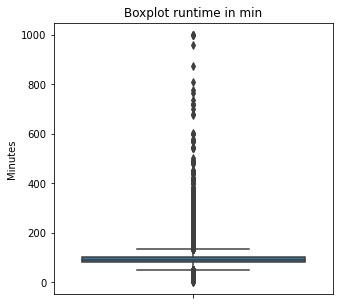

In [36]:
outliers = db_movies[db_movies['runtimeMinutes']>1000]['runtimeMinutes'].count() 
outliers


db_movies= db_movies[db_movies['runtimeMinutes']<1000]

# New distribution

plt.figure(figsize=(5,5))
plt.subplot()
fig = sns.boxplot(y='runtimeMinutes', data=db_movies, orient='v')
fig.set_title('Boxplot runtime in min')
fig.set_ylabel('Minutes')

In [37]:
# Estimating the remaining ammount of outliers in the data

db_new = db_movies[db_movies['runtimeMinutes']>200]['runtimeMinutes'].count() 
out_perc = (db_new/db_movies.shape[0])*100
out_perc

0.40081209767730397

As the remaining outliers represent less than 0,5% of the examples, we will also drop these values (movies with 200 min are +3h movies yet, i.e., these are more feasible cases of long movies)

Text(0, 0.5, 'Minutes')

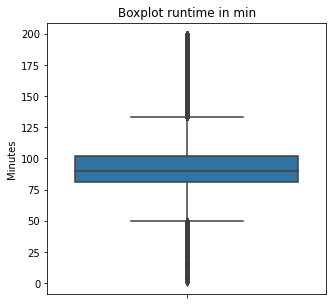

In [38]:
db_movies= db_movies[db_movies['runtimeMinutes']<200]

# New distribution

plt.figure(figsize=(5,5))
plt.subplot()
fig = sns.boxplot(y='runtimeMinutes', data=db_movies, orient='v')
fig.set_title('Boxplot runtime in min')
fig.set_ylabel('Minutes')

In [39]:
db_movies.reset_index(drop=True, inplace=True)
db_movies

,titleId,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers,translations,directorsCount,writersCount,genresCount,1stGenre,RatingClass,lengthCategory
0,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography",6.0,765,nm0846879,nm0846879,9,1,1,3,Action,1,1
1,tt0000591,movie,The Prodigal Son,L'enfant prodigue,1907,90,Drama,4.5,18,nm0141150,nm0141150,2,1,1,1,Drama,0,2
2,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,1908,120,"Adventure,Fantasy",5.3,66,"nm0091767,nm0877783","nm0000875,nm0877783",2,2,2,2,Adventure,0,2
3,tt0001184,movie,Don Juan de Serrallonga,Don Juan de Serrallonga,1910,58,"Adventure,Drama",3.9,20,"nm0550220,nm0063413",nm0049370,1,2,1,2,Adventure,0,1
4,tt0001285,movie,The Life of Moses,The Life of Moses,1909,50,"Biography,Drama,Family",5.6,58,nm0085865,"nm0676645,nm0836316",7,1,2,3,Biography,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247064,tt9909424,tvMovie,Razreshite tebya potselovat... Otets nevesty,Razreshite tebya potselovat... Otets nevesty,2014,90,Comedy,4.6,6,nm5620850,"nm3576575,nm0606159",2,1,2,1,Comedy,0,2
247065,tt9910984,tvMovie,Rivalen der Renaissance: Bellini und Mantegna,Rivalen der Renaissance: Bellini und Mantegna,2018,53,Documentary,7.4,8,nm5954264,nm5954264,3,1,1,1,Documentary,2,1
247066,tt9913544,tvMovie,An American Named Kazan,Un Américain nommé Kazan,2018,53,"Biography,Documentary",7.1,20,nm1701148,nm1701148,3,1,1,2,Biography,1,1
247067,tt9915520,tvMovie,Fascism i en svart bil,Fascism i en svart bil,2019,55,"Documentary,History",6.9,7,nm8744716,"nm9513757,nm8744716",2,1,2,2,Documentary,1,1


Categorizing variables **[titleType]** and **[1stGenre]**

In [40]:
dumType = pd.get_dummies(db_movies['titleType'])
db_movies = pd.concat([db_movies,dumType], axis=1)

dumGenre = pd.get_dummies(db_movies['1stGenre'])
db_movies = pd.concat([db_movies,dumGenre], axis=1)

### Correlation tests

In [41]:
db_movies.startYear.apply(lambda x: int(x))

0         1906
1         1907
2         1908
3         1910
4         1909
          ... 
247064    2014
247065    2018
247066    2018
247067    2019
247068    2019
Name: startYear, Length: 247069, dtype: int64

Text(0.5, 1.0, 'Spearman Correlation')

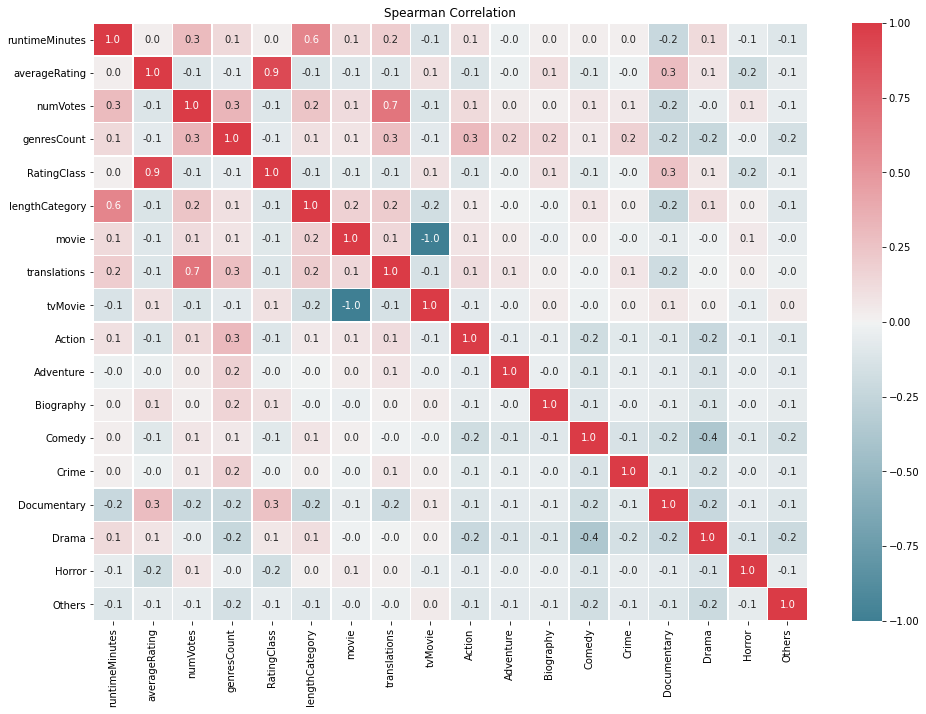

In [42]:
# Variables to be evaluated
cluster = db_movies[['startYear', 'runtimeMinutes', 'averageRating', 'numVotes',
       'genresCount', 'RatingClass', 'lengthCategory', 'movie', 'translations', 'tvMovie', 
        'Action', 'Adventure', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Others']]



# Spearman plot configuration
cluster1 = cluster.corr(method = 'spearman')
mask = np.zeros_like(cluster1, dtype=np.bool)

mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap = True)


# PLOT 1

fig, ax = plt.subplots(figsize=(16,11))

# Spearman
sns.heatmap(cluster1, annot=True, linewidths=0.5, ax=ax, fmt='.1f', cmap=cmap)
ax.set_title('Spearman Correlation')

Text(0.5, 1.0, 'Pearson Correlation')

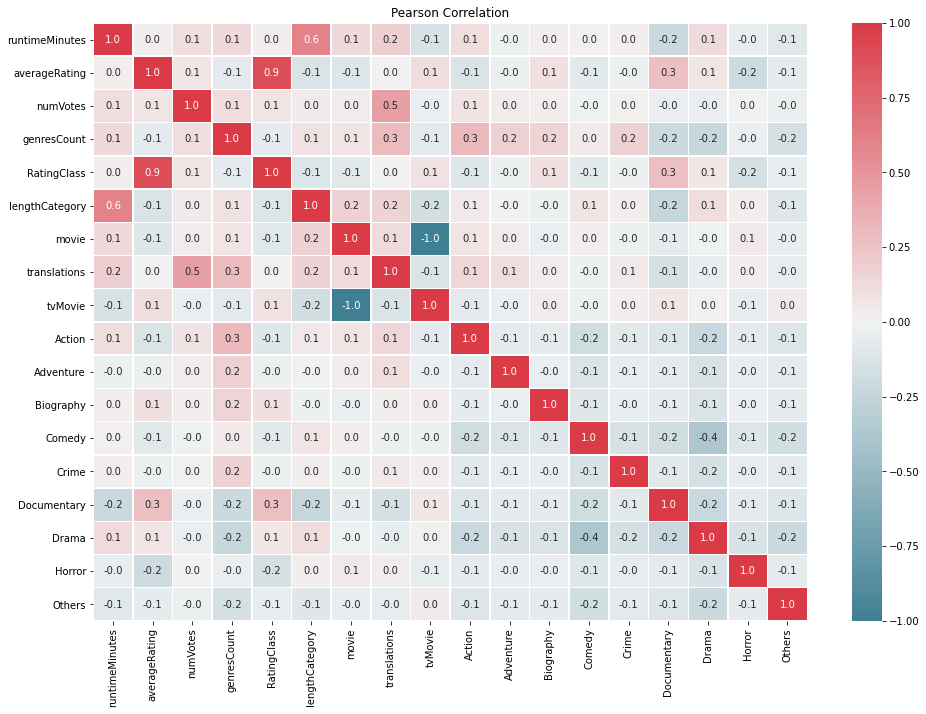

In [43]:
# Pearson plot configuration
cluster2 = cluster.corr(method = 'pearson')
mask = np.zeros_like(cluster2, dtype=np.bool)

mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap = True)


# PLOT 2

fig, ax = plt.subplots(figsize=(16,11))

# Pearson
sns.heatmap(cluster2, annot=True, linewidths=0.5, ax=ax, fmt='.1f', cmap=cmap)
ax.set_title('Pearson Correlation')

Some of the features present a medium to high correlation:

- ['runtimeMinutes'] X ['lenghCategory']

- ['averageRating'] X ['RatingClass']

- ['numVotes'] X ['translations']

As these raw features were discretized to improve the model, we will drop them:

Text(0.5, 1.0, 'Spearman Correlation')

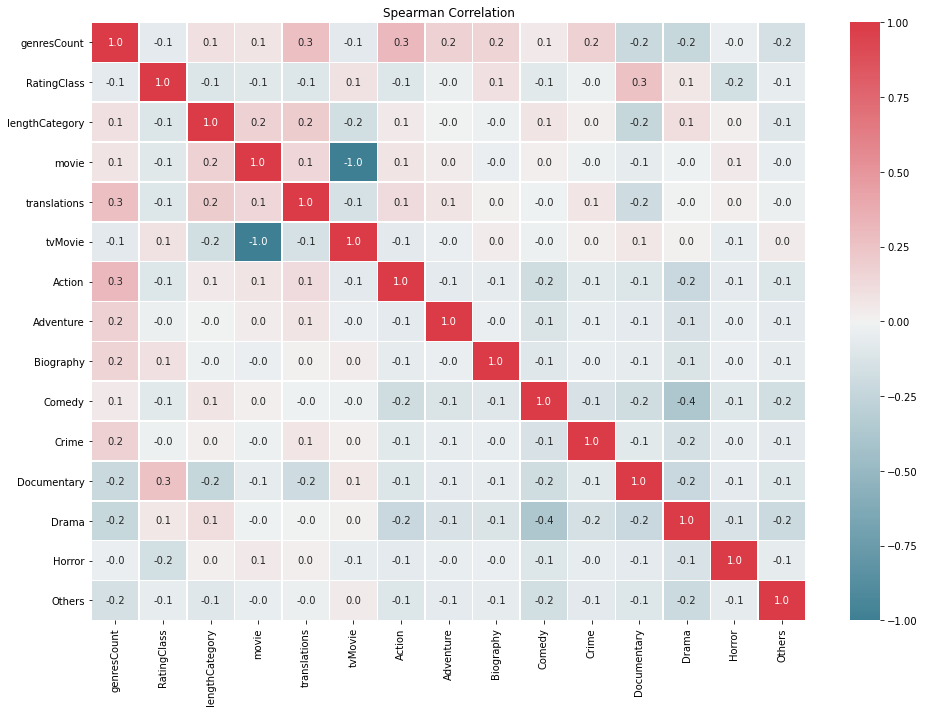

In [44]:
# Variables to be evaluated
new_cluster = db_movies[['startYear', 'genresCount', 'RatingClass', 'lengthCategory', 'movie', 'translations', 'tvMovie', 
        'Action', 'Adventure', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Others']]



# Spearman plot configuration
cluster1 = new_cluster.corr(method = 'spearman')
mask = np.zeros_like(cluster1, dtype=np.bool)

mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap = True)


# PLOT 1

fig, ax = plt.subplots(figsize=(16,11))

# Spearman
sns.heatmap(cluster1, annot=True, linewidths=0.5, ax=ax, fmt='.1f', cmap=cmap)
ax.set_title('Spearman Correlation')

<AxesSubplot:xlabel='RatingClass', ylabel='translations'>

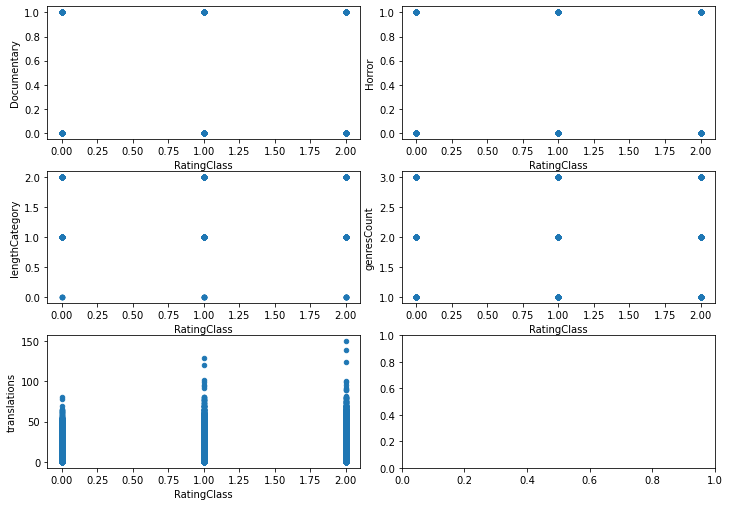

In [45]:
# PLOTS

fig, axs = plt.subplots(3,2, figsize=(10,7))
fig.tight_layout()

db_movies.plot.scatter('RatingClass','Documentary', ax=axs[0,0])
db_movies.plot.scatter('RatingClass', 'Horror', ax=axs[0,1])
db_movies.plot.scatter('RatingClass', 'lengthCategory', ax=axs[1,0])
db_movies.plot.scatter('RatingClass', 'genresCount', ax=axs[1,1])
db_movies.plot.scatter('RatingClass', 'translations', ax=axs[2,0])

### Splitting the data

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
y = db_movies['RatingClass']
x = new_cluster.drop('RatingClass', axis=1)

In [48]:
x.columns

Index(['startYear', 'genresCount', 'lengthCategory', 'movie', 'translations',
       'tvMovie', 'Action', 'Adventure', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Horror', 'Others'],
      dtype='object')

In [49]:
x["startYear"] = x['startYear'].astype('float')
x.dtypes

startYear         float64
genresCount         int64
lengthCategory      int64
movie               uint8
translations        int64
tvMovie             uint8
Action              uint8
Adventure           uint8
Biography           uint8
Comedy              uint8
Crime               uint8
Documentary         uint8
Drama               uint8
Horror              uint8
Others              uint8
dtype: object

In [50]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
x['startYear'] = lbl.fit_transform(x['startYear'].astype(str))

In [51]:
x.dtypes

startYear         int64
genresCount       int64
lengthCategory    int64
movie             uint8
translations      int64
tvMovie           uint8
Action            uint8
Adventure         uint8
Biography         uint8
Comedy            uint8
Crime             uint8
Documentary       uint8
Drama             uint8
Horror            uint8
Others            uint8
dtype: object

In [52]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.30, random_state=42)

In [53]:
print('Quantidade de exemplos de treino:', xtrain.shape[0])
print('Quantidade de resultados de treino:', ytrain.shape[0])
print('Quantidade de exemplos de teste:', xtest.shape[0])
print('Quantidade de resultados de teste:', ytest.shape[0])

Quantidade de exemplos de treino: 172948
Quantidade de resultados de treino: 172948
Quantidade de exemplos de teste: 74121
Quantidade de resultados de teste: 74121


Applying the ML methods using the Pipeline

### Model 1: Logistic Regression

In [54]:
# Metrics
from sklearn.metrics import roc_auc_score, make_scorer

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

# Methods
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [55]:
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1, solver='saga')

# Set the steps of the pipeline
pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])

# Set the parameters grid to be tested.Parameters of pipelines can be set using ‘__’ separated parameter names: 
param_grid = {"logistic__C": [0.01, 0.1, 1],
             "logistic__penalty":['l1','l2']} 

# CV conditions = default 5-fold

scoring_list = ["roc_auc_ovr", "precision_macro"]

# set the Grid search CV
search = GridSearchCV(pipe, 
                      param_grid, 
                      n_jobs=2, 
                      scoring=scoring_list,
#                      scoring="roc_auc_ovr",
                     refit='roc_auc_ovr',
                      verbose=3,
                      return_train_score=True
                     )

search.fit(xtrain, ytrain)
results = search.cv_results_
method = search.best_estimator_

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print("Best parameters: ", search.best_params_)
print("Best index: ", search.best_index_)
print("Best estimator: ", search.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameter (CV score=0.663):
Best parameters:  {'logistic__C': 1, 'logistic__penalty': 'l1'}
Best index:  4
Best estimator:  Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic',
                 LogisticRegression(C=1, max_iter=10000, penalty='l1',
                                    solver='saga', tol=0.1))])


In [81]:
y_pred_lr = method.predict_proba(xtest)
pd.DataFrame(y_pred_lr)

,0,1,2
0,0.271902,0.559360,0.168738
1,0.503607,0.402820,0.093573
2,0.270702,0.486025,0.243274
3,0.157898,0.714201,0.127901
4,0.328077,0.492112,0.179812
...,...,...,...
74116,0.339460,0.546042,0.114498
74117,0.274451,0.630601,0.094948
74118,0.233024,0.633477,0.133499
74119,0.757317,0.210550,0.032133


In [56]:
results_df = pd.DataFrame(results)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,params,split0_test_roc_auc_ovr,split1_test_roc_auc_ovr,split2_test_roc_auc_ovr,...,mean_test_precision_macro,std_test_precision_macro,rank_test_precision_macro,split0_train_precision_macro,split1_train_precision_macro,split2_train_precision_macro,split3_train_precision_macro,split4_train_precision_macro,mean_train_precision_macro,std_train_precision_macro
0,0.524224,0.059022,0.077064,0.025893,0.01,l1,"{'logistic__C': 0.01, 'logistic__penalty': 'l1'}",0.662677,0.662537,0.659736,...,0.518498,0.006860,2,0.519248,0.517639,0.516721,0.516688,0.519200,0.517899,0.001134
1,0.465828,0.043321,0.060586,0.002766,0.01,l2,"{'logistic__C': 0.01, 'logistic__penalty': 'l2'}",0.662644,0.663749,0.658751,...,0.516733,0.004812,6,0.520480,0.517341,0.517057,0.514406,0.514973,0.516851,0.002143
2,0.618917,0.062105,0.056449,0.007174,0.1,l1,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'}",0.662545,0.663147,0.660050,...,0.517287,0.005347,4,0.519254,0.519228,0.520365,0.514780,0.516693,0.518064,0.002036
3,0.447183,0.082289,0.062527,0.002525,0.1,l2,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'}",0.661993,0.663742,0.660007,...,0.516773,0.005727,5,0.516377,0.517165,0.517139,0.515439,0.520905,0.517405,0.001860
4,0.622895,0.061418,0.061797,0.002544,1,l1,"{'logistic__C': 1, 'logistic__penalty': 'l1'}",0.662524,0.663129,0.660157,...,0.517620,0.006103,3,0.517266,0.518528,0.517596,0.516448,0.517978,0.517563,0.000698
5,0.494464,0.024809,0.062561,0.002968,1,l2,"{'logistic__C': 1, 'logistic__penalty': 'l2'}",0.662635,0.662958,0.659532,...,0.518536,0.009142,1,0.518359,0.517676,0.515249,0.521176,0.518555,0.518203,0.001897


In [57]:
best_log = results_df[results_df['rank_test_roc_auc_ovr']==1]

In [58]:
data_log = results_df[[x for x in results_df.columns if 'roc_auc_ovr' in x]].T
data_log

,0,1,2,3,4,5
split0_test_roc_auc_ovr,0.662677,0.662644,0.662545,0.661993,0.662524,0.662635
split1_test_roc_auc_ovr,0.662537,0.663749,0.663147,0.663742,0.663129,0.662958
split2_test_roc_auc_ovr,0.659736,0.658751,0.660050,0.660007,0.660157,0.659532
split3_test_roc_auc_ovr,0.666876,0.666011,0.665952,0.665708,0.666330,0.666673
split4_test_roc_auc_ovr,0.664262,0.665467,0.664898,0.664233,0.665021,0.665186
mean_test_roc_auc_ovr,0.663218,0.663324,0.663318,0.663137,0.663432,0.663396
std_test_roc_auc_ovr,0.002339,0.002583,0.002037,0.001964,0.002125,0.002435
rank_test_roc_auc_ovr,5.000000,3.000000,4.000000,6.000000,1.000000,2.000000
split0_train_roc_auc_ovr,0.664199,0.664122,0.664088,0.663774,0.663906,0.664131
split1_train_roc_auc_ovr,0.663173,0.663713,0.663444,0.663778,0.663230,0.663284


### Model 2: Random Forest

In [59]:
# Define a Standard Scaler to normalize inputs
#scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
RF = RandomForestClassifier() # using Gini Impurity algorithm (default)
    
# Set the steps of the pipeline
pipe = Pipeline(steps=[("RF", RF)])

# Set the parameters grid to be tested.Parameters of pipelines can be set using ‘__’ separated parameter names: 
param_grid = {"RF__n_estimators": [50, 75, 100],
             #"RF__max_features":['sqrt','log2'],
              "RF__max_depth":[5,10],
#             "RF__bootstrap": [True, False]
             } 

# CV conditions = default 5-fold

scoring_list = ["roc_auc_ovr", "precision_macro"]

# set the Grid search CV
search2 = GridSearchCV(pipe, 
                      param_grid, 
                      n_jobs=2, 
                      scoring=scoring_list,
                      refit='roc_auc_ovr',
                      verbose=2,
                      return_train_score=True,
                       cv=3
                     )

search2.fit(xtrain, ytrain)
results2 = search2.cv_results_
method2 = search2.best_estimator_

print("Best parameter (CV score=%0.3f):" % search2.best_score_)
print("Best parameters: ", search2.best_params_)
print("Best index: ", search2.best_index_)
print("Best estimator: ", search2.best_estimator_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameter (CV score=0.713):
Best parameters:  {'RF__max_depth': 10, 'RF__n_estimators': 100}
Best index:  5
Best estimator:  Pipeline(steps=[('RF', RandomForestClassifier(max_depth=10))])


In [82]:
y_pred_rf = method2.predict_proba(xtest)
pd.DataFrame(y_pred_rf)

,0,1,2
0,0.305015,0.581449,0.113537
1,0.489109,0.423528,0.087363
2,0.222697,0.389222,0.388081
3,0.124880,0.763169,0.111951
4,0.266719,0.461776,0.271505
...,...,...,...
74116,0.447007,0.474201,0.078793
74117,0.161144,0.745852,0.093003
74118,0.266965,0.602813,0.130221
74119,0.832411,0.149274,0.018315


In [60]:
results2_df = pd.DataFrame(results2)
results2_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_RF__max_depth', 'param_RF__n_estimators', 'params',
       'split0_test_roc_auc_ovr', 'split1_test_roc_auc_ovr',
       'split2_test_roc_auc_ovr', 'mean_test_roc_auc_ovr',
       'std_test_roc_auc_ovr', 'rank_test_roc_auc_ovr',
       'split0_train_roc_auc_ovr', 'split1_train_roc_auc_ovr',
       'split2_train_roc_auc_ovr', 'mean_train_roc_auc_ovr',
       'std_train_roc_auc_ovr', 'split0_test_precision_macro',
       'split1_test_precision_macro', 'split2_test_precision_macro',
       'mean_test_precision_macro', 'std_test_precision_macro',
       'rank_test_precision_macro', 'split0_train_precision_macro',
       'split1_train_precision_macro', 'split2_train_precision_macro',
       'mean_train_precision_macro', 'std_train_precision_macro'],
      dtype='object')

In [61]:
best_rf = results2_df[results2_df['rank_test_roc_auc_ovr']==1]

In [62]:
data_rf = results2_df[[x for x in results2_df.columns if 'roc_auc_ovr' in x]].T
data_rf

,0,1,2,3,4,5
split0_test_roc_auc_ovr,0.691851,0.691191,0.691571,0.712212,0.712397,0.713373
split1_test_roc_auc_ovr,0.691387,0.692253,0.691795,0.711632,0.711487,0.712067
split2_test_roc_auc_ovr,0.693776,0.693934,0.693641,0.713303,0.713642,0.714011
mean_test_roc_auc_ovr,0.692338,0.692459,0.692336,0.712383,0.712509,0.713150
std_test_roc_auc_ovr,0.001034,0.001129,0.000928,0.000693,0.000884,0.000809
rank_test_roc_auc_ovr,5.000000,4.000000,6.000000,3.000000,2.000000,1.000000
split0_train_roc_auc_ovr,0.694243,0.693546,0.694187,0.729405,0.729383,0.730835
split1_train_roc_auc_ovr,0.694659,0.695481,0.694829,0.730743,0.730139,0.731841
split2_train_roc_auc_ovr,0.693841,0.693633,0.693771,0.730764,0.730722,0.730948
mean_train_roc_auc_ovr,0.694248,0.694220,0.694263,0.730304,0.730081,0.731208


### Model 3: GBM (Gradient Booster Machine)

In [63]:
GBM = GradientBoostingClassifier() 
    
# Set the steps of the pipeline
pipe = Pipeline(steps=[("GBM", GBM)])

# Set the parameters grid to be tested.Parameters of pipelines can be set using ‘__’ separated parameter names: 
param_grid = {"GBM__n_estimators": [50, 75, 100],
              "GBM__learning_rate":[0.01, 0.1],
              "GBM__max_depth": [5,10]
             } 

# CV conditions = default 5-fold

scoring_list = ["roc_auc_ovr", "precision_macro"]

# set the Grid search CV
search3 = GridSearchCV(pipe, 
                      param_grid, 
                      n_jobs=2, 
                      scoring=scoring_list,
                      refit='roc_auc_ovr',
                      verbose=2,
                      return_train_score=True,
                       cv=3
                     )

search3.fit(xtrain, ytrain)
results3 = search3.cv_results_
method3 = search3.best_estimator_

print("Best parameter (CV score=%0.3f):" % search3.best_score_)
print("Best parameters: ", search3.best_params_)
print("Best index: ", search3.best_index_)
print("Best estimator: ", search3.best_estimator_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameter (CV score=0.717):
Best parameters:  {'GBM__learning_rate': 0.1, 'GBM__max_depth': 5, 'GBM__n_estimators': 100}
Best index:  8
Best estimator:  Pipeline(steps=[('GBM', GradientBoostingClassifier(max_depth=5))])


In [80]:
y_pred_gbm = method3.predict_proba(xtest)
pd.DataFrame(y_pred_gbm)

,0,1,2
0,0.300681,0.611438,0.087881
1,0.533366,0.406077,0.060558
2,0.190996,0.321150,0.487853
3,0.045152,0.849157,0.105691
4,0.250933,0.464508,0.284559
...,...,...,...
74116,0.518090,0.420347,0.061563
74117,0.121640,0.825267,0.053093
74118,0.272611,0.580461,0.146927
74119,0.874600,0.118186,0.007215


In [64]:
results3_df = pd.DataFrame(results3)
results3_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_GBM__learning_rate,param_GBM__max_depth,param_GBM__n_estimators,params,split0_test_roc_auc_ovr,split1_test_roc_auc_ovr,...,split1_test_precision_macro,split2_test_precision_macro,mean_test_precision_macro,std_test_precision_macro,rank_test_precision_macro,split0_train_precision_macro,split1_train_precision_macro,split2_train_precision_macro,mean_train_precision_macro,std_train_precision_macro
0,19.221486,0.054054,0.438555,0.014861,0.01,5,50,"{'GBM__learning_rate': 0.01, 'GBM__max_depth':...",0.692100,0.693472,...,0.696213,0.695246,0.703935,0.011612,1,0.718714,0.704142,0.714789,0.712548,0.006156
1,28.732057,0.188745,0.649799,0.005544,0.01,5,75,"{'GBM__learning_rate': 0.01, 'GBM__max_depth':...",0.695320,0.696500,...,0.693234,0.690058,0.697218,0.007986,2,0.702602,0.703925,0.705453,0.703994,0.001165
2,38.291785,0.484185,0.842513,0.025108,0.01,5,100,"{'GBM__learning_rate': 0.01, 'GBM__max_depth':...",0.697739,0.698543,...,0.664124,0.675942,0.679019,0.013593,3,0.688290,0.684302,0.690982,0.687858,0.002744
3,38.878335,0.169354,0.988887,0.012449,0.01,10,50,"{'GBM__learning_rate': 0.01, 'GBM__max_depth':...",0.708127,0.705245,...,0.664992,0.675461,0.671415,0.004593,4,0.738925,0.750204,0.755321,0.748150,0.006850
4,58.139969,0.557731,1.561103,0.166361,0.01,10,75,"{'GBM__learning_rate': 0.01, 'GBM__max_depth':...",0.710137,0.707502,...,0.604268,0.610968,0.614344,0.009897,5,0.696374,0.688643,0.692009,0.692342,0.003165
5,81.347961,0.648056,2.005722,0.028202,0.01,10,100,"{'GBM__learning_rate': 0.01, 'GBM__max_depth':...",0.711518,0.709063,...,0.580078,0.587793,0.586000,0.004295,6,0.636844,0.648493,0.653192,0.646176,0.006872
6,19.121794,0.306140,0.442960,0.006278,0.1,5,50,"{'GBM__learning_rate': 0.1, 'GBM__max_depth': ...",0.712827,0.712467,...,0.551918,0.551501,0.552254,0.000788,9,0.561860,0.563876,0.561642,0.562459,0.001006
7,29.834049,0.653068,0.615232,0.030162,0.1,5,75,"{'GBM__learning_rate': 0.1, 'GBM__max_depth': ...",0.715431,0.715124,...,0.552274,0.552106,0.552965,0.001099,7,0.563520,0.564945,0.564403,0.564289,0.000587
8,39.611892,0.713702,0.741654,0.011913,0.1,5,100,"{'GBM__learning_rate': 0.1, 'GBM__max_depth': ...",0.717252,0.716356,...,0.552927,0.551579,0.552429,0.000604,8,0.565231,0.566932,0.565758,0.565974,0.000711
9,38.874501,0.643409,0.915175,0.006303,0.1,10,50,"{'GBM__learning_rate': 0.1, 'GBM__max_depth': ...",0.713564,0.711239,...,0.545018,0.544266,0.545160,0.000794,10,0.618617,0.621093,0.613867,0.617859,0.002998


In [65]:
best_gbm = results3_df[results3_df['rank_test_roc_auc_ovr']==1]

In [66]:
data_gbm = results3_df[[x for x in results3_df.columns if 'roc_auc_ovr' in x]].T
data_gbm

,0,1,2,3,4,5,6,7,8,9,10,11
split0_test_roc_auc_ovr,0.692100,0.695320,0.697739,0.708127,0.710137,0.711518,0.712827,0.715431,0.717252,0.713564,0.711353,0.708365
split1_test_roc_auc_ovr,0.693472,0.696500,0.698543,0.705245,0.707502,0.709063,0.712467,0.715124,0.716356,0.711239,0.709354,0.705241
split2_test_roc_auc_ovr,0.693659,0.697027,0.698912,0.708795,0.710168,0.711194,0.713705,0.716265,0.717567,0.712670,0.710260,0.707954
mean_test_roc_auc_ovr,0.693077,0.696282,0.698398,0.707389,0.709269,0.710592,0.713000,0.715606,0.717059,0.712491,0.710322,0.707187
std_test_roc_auc_ovr,0.000695,0.000714,0.000490,0.001541,0.001250,0.001089,0.000520,0.000482,0.000513,0.000958,0.000817,0.001386
rank_test_roc_auc_ovr,12.000000,11.000000,10.000000,8.000000,7.000000,5.000000,3.000000,2.000000,1.000000,4.000000,6.000000,9.000000
split0_train_roc_auc_ovr,0.695891,0.699069,0.701454,0.732366,0.736048,0.739093,0.719650,0.724180,0.727738,0.777921,0.793816,0.803451
split1_train_roc_auc_ovr,0.695912,0.699208,0.701618,0.732825,0.736606,0.739895,0.720401,0.725291,0.728381,0.776912,0.790941,0.804130
split2_train_roc_auc_ovr,0.694842,0.698708,0.700914,0.732828,0.736014,0.739020,0.719951,0.724713,0.727903,0.773702,0.789925,0.801092
mean_train_roc_auc_ovr,0.695548,0.698995,0.701329,0.732673,0.736223,0.739336,0.720001,0.724728,0.728007,0.776178,0.791561,0.802891


### Model 4: Light GBM (LGBM)

In [67]:
from lightgbm import LGBMClassifier

In [68]:
LGBM = LGBMClassifier() 
    
# Set the steps of the pipeline
pipe = Pipeline(steps=[("LGBM", LGBM)])

# Set the parameters grid to be tested.Parameters of pipelines can be set using ‘__’ separated parameter names: 
param_grid = {"LGBM__n_estimators": [50, 75, 100],
              "LGBM__learning_rate":[0.001, 0.01, 0.1],
              "LGBM__max_depth": [3,5,10]
             } 

# CV conditions = default 5-fold

scoring_list = ["roc_auc_ovr", "precision_macro"]

# set the Grid search CV
search4 = GridSearchCV(pipe, 
                      param_grid, 
                      n_jobs=2, 
                      scoring=scoring_list,
                      refit='roc_auc_ovr',
                      verbose=2,
                      return_train_score=True,
                       cv=3
                     )

search4.fit(xtrain, ytrain)
results4 = search4.cv_results_
method4 = search4.best_estimator_

print("Best parameter (CV score=%0.3f):" % search4.best_score_)
print("Best parameters: ", search4.best_params_)
print("Best index: ", search4.best_index_)
print("Best estimator: ", search4.best_estimator_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameter (CV score=0.719):
Best parameters:  {'LGBM__learning_rate': 0.1, 'LGBM__max_depth': 10, 'LGBM__n_estimators': 100}
Best index:  26
Best estimator:  Pipeline(steps=[('LGBM', LGBMClassifier(max_depth=10))])


In [83]:
y_pred_lgbm = method4.predict_proba(xtest)
pd.DataFrame(y_pred_lgbm)

,0,1,2
0,0.316032,0.599644,0.084324
1,0.550828,0.378752,0.070420
2,0.204203,0.334220,0.461577
3,0.053691,0.829301,0.117007
4,0.254477,0.454355,0.291168
...,...,...,...
74116,0.568127,0.394761,0.037112
74117,0.117468,0.828241,0.054291
74118,0.267959,0.586819,0.145222
74119,0.873637,0.121947,0.004416


In [74]:
results4_df = pd.DataFrame(results4)
results4_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_LGBM__learning_rate,param_LGBM__max_depth,param_LGBM__n_estimators,params,split0_test_roc_auc_ovr,split1_test_roc_auc_ovr,...,split1_test_precision_macro,split2_test_precision_macro,mean_test_precision_macro,std_test_precision_macro,rank_test_precision_macro,split0_train_precision_macro,split1_train_precision_macro,split2_train_precision_macro,mean_train_precision_macro,std_train_precision_macro
0,0.589596,0.079184,0.253189,0.029603,0.001,3,50,"{'LGBM__learning_rate': 0.001, 'LGBM__max_dept...",0.658758,0.662647,...,0.167606,0.167600,0.167603,0.000002,19,0.167603,0.167602,0.167605,0.167603,0.000001
1,0.832456,0.025855,0.366121,0.022753,0.001,3,75,"{'LGBM__learning_rate': 0.001, 'LGBM__max_dept...",0.658520,0.664536,...,0.167606,0.167600,0.167603,0.000002,19,0.167603,0.167602,0.167605,0.167603,0.000001
2,1.185751,0.171645,0.466596,0.038899,0.001,3,100,"{'LGBM__learning_rate': 0.001, 'LGBM__max_dept...",0.659906,0.664482,...,0.167606,0.167600,0.167603,0.000002,19,0.167603,0.167602,0.167605,0.167603,0.000001
3,0.796570,0.100527,0.400575,0.041520,0.001,5,50,"{'LGBM__learning_rate': 0.001, 'LGBM__max_dept...",0.680774,0.684803,...,0.167606,0.167600,0.167603,0.000002,19,0.167603,0.167602,0.167605,0.167603,0.000001
4,1.156343,0.216693,0.600660,0.049691,0.001,5,75,"{'LGBM__learning_rate': 0.001, 'LGBM__max_dept...",0.682267,0.685344,...,0.167606,0.167600,0.167603,0.000002,19,0.167603,0.167602,0.167605,0.167603,0.000001
5,1.447166,0.111524,0.864928,0.080989,0.001,5,100,"{'LGBM__learning_rate': 0.001, 'LGBM__max_dept...",0.683676,0.685734,...,0.167606,0.167600,0.167603,0.000002,19,0.167603,0.167602,0.167605,0.167603,0.000001
6,1.075761,0.140424,0.453892,0.042328,0.001,10,50,"{'LGBM__learning_rate': 0.001, 'LGBM__max_dept...",0.700380,0.701536,...,0.167606,0.167600,0.167603,0.000002,19,0.167603,0.167602,0.167605,0.167603,0.000001
7,1.309763,0.078674,0.656538,0.007613,0.001,10,75,"{'LGBM__learning_rate': 0.001, 'LGBM__max_dept...",0.700525,0.701955,...,0.167606,0.167600,0.167603,0.000002,19,0.167603,0.167602,0.167605,0.167603,0.000001
8,1.812418,0.036608,1.000477,0.089933,0.001,10,100,"{'LGBM__learning_rate': 0.001, 'LGBM__max_dept...",0.700855,0.702089,...,0.167606,0.167600,0.167603,0.000002,19,0.167603,0.167602,0.167605,0.167603,0.000001
9,0.567882,0.007957,0.341300,0.035737,0.01,3,50,"{'LGBM__learning_rate': 0.01, 'LGBM__max_depth...",0.672468,0.676380,...,0.424491,0.428132,0.428967,0.004038,17,0.426367,0.430867,0.429486,0.428907,0.001883


In [75]:
best_lgbm = results4_df[results4_df['rank_test_roc_auc_ovr']==1]

In [76]:
data_lgbm = results4_df[[x for x in results4_df.columns if 'roc_auc_ovr' in x]].T
data_lgbm

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
split0_test_roc_auc_ovr,0.658758,0.658520,0.659906,0.680774,0.682267,0.683676,0.700380,0.700525,0.700855,0.672468,...,0.708351,0.699627,0.704013,0.706715,0.712179,0.714957,0.716927,0.717680,0.718593,0.719200
split1_test_roc_auc_ovr,0.662647,0.664536,0.664482,0.684803,0.685344,0.685734,0.701536,0.701955,0.702089,0.676380,...,0.707984,0.700813,0.704080,0.706692,0.712356,0.714946,0.716612,0.716890,0.717917,0.718626
split2_test_roc_auc_ovr,0.661514,0.662622,0.662935,0.681837,0.682269,0.682563,0.701013,0.701530,0.701989,0.676486,...,0.709060,0.702063,0.705758,0.708187,0.712980,0.715733,0.717222,0.717808,0.718793,0.719372
mean_test_roc_auc_ovr,0.660973,0.661893,0.662441,0.682472,0.683294,0.683991,0.700976,0.701337,0.701644,0.675111,...,0.708465,0.700834,0.704617,0.707198,0.712505,0.715212,0.716920,0.717459,0.718434,0.719066
std_test_roc_auc_ovr,0.001633,0.002510,0.001900,0.001705,0.001450,0.001313,0.000473,0.000599,0.000560,0.001870,...,0.000447,0.000995,0.000807,0.000699,0.000344,0.000368,0.000249,0.000406,0.000375,0.000319
rank_test_roc_auc_ovr,27.000000,26.000000,25.000000,21.000000,20.000000,19.000000,14.000000,13.000000,12.000000,24.000000,...,7.000000,15.000000,11.000000,8.000000,6.000000,5.000000,4.000000,3.000000,2.000000,1.000000
split0_train_roc_auc_ovr,0.661888,0.662103,0.663681,0.684716,0.686008,0.687251,0.703529,0.703735,0.704036,0.675216,...,0.711603,0.702358,0.706829,0.710032,0.718191,0.722568,0.726019,0.725420,0.729181,0.732377
split1_train_roc_auc_ovr,0.662546,0.664600,0.664654,0.687474,0.688051,0.688369,0.704455,0.704809,0.705001,0.676962,...,0.712013,0.703414,0.706873,0.710063,0.719171,0.723574,0.727240,0.726260,0.730258,0.733817
split2_train_roc_auc_ovr,0.661249,0.662315,0.662577,0.682739,0.683395,0.683706,0.702369,0.702946,0.703594,0.675504,...,0.711590,0.702725,0.707387,0.710512,0.717785,0.722131,0.725357,0.725589,0.729676,0.733233
mean_train_roc_auc_ovr,0.661894,0.663006,0.663637,0.684976,0.685818,0.686442,0.703451,0.703830,0.704210,0.675894,...,0.711735,0.702832,0.707030,0.710202,0.718382,0.722757,0.726205,0.725756,0.729705,0.733142


### Model Comparison

Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


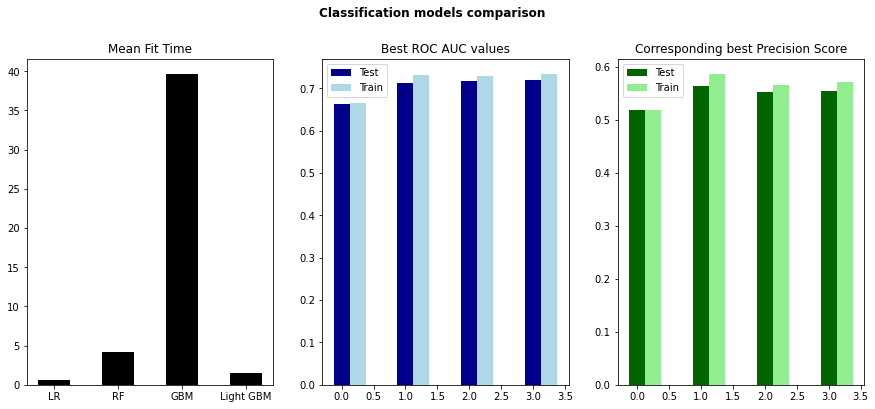

In [124]:
models = [best_log, best_rf, best_gbm, best_lgbm]

# Captures time length to fit each model
time = [ round(float(X['mean_fit_time'].values), 3) for X in models]

# Captures best models ROC indexes
test_roc = [ round(float(X['mean_test_roc_auc_ovr'].values), 3) for X in models]
train_roc = [ round(float(X['mean_train_roc_auc_ovr'].values), 3) for X in models]

# Captures best models corresponding precision indexes
test_precision = [ round(float(X['mean_test_precision_macro'].values), 3) for X in models]
train_precision = [ round(float(X['mean_train_precision_macro'].values), 3) for X in models]

# PLOTS

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,6))
fig.suptitle('Classification models comparison', y=1, weight='bold')

labels = ['LR', 'RF', 'GBM', 'Light GBM']
width =0.5

ax1.bar(labels, time, width, color='black')
ax1.set_title('Mean Fit Time')

# Bar width
barWidth = 0.25
r1 = np.arange(len(test_roc))
r2 = [x + barWidth for x in r1]

ax2.bar(r1, test_roc, barWidth, color='darkblue', label='Test')
ax2.bar(r2, train_roc, barWidth, color='lightblue', label='Train')
ax2.set_title('Best ROC AUC values')
ax2.set_xticks(r1, labels)
ax2.legend()

ax3.bar(r1, test_precision, barWidth, color='darkgreen', label='Test')
ax3.bar(r2, train_precision, barWidth, color='lightgreen', label='Train')
ax3.set_title('Corresponding best Precision Score')
ax3.set_xticks(r1, labels)
ax3.legend()


#### Probability Calibration

In [77]:
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay

In [70]:
# Model Calibration
def calib_curve_probs(y_true, y_probs, n_bins: int = 10, method: str = 'uniform'):
    """Binary classification calibration curve and probas
    Parameters
    ----------
    y_true: array
        true class observations
    y_preds: array
        model predictions
    n_bins: int (default = 10)
    method: str (default = "uniform")
        whether to use "uniform" or "quantile" for probability binning
    Returns
    -------
    x, y, p: Average score, Fra
    
    """
    assert method in ['quantile', 'uniform'], "Unrecognized method"
    
    predictions = pd.DataFrame({
        'label': y_true,
        'scores': y_probs,
        })
    
    predictions = predictions.sort_values('scores')
    
    if method == 'quantile':
        quantiles = [predictions['scores'].quantile(q) for q in np.linspace(0, 1, n_bins+1)] 
        predictions['bins'] = pd.cut(predictions['scores'], quantiles)

    else:
        bins=np.linspace(0, 1, n_bins+1) 
        predictions['bins'] = pd.cut(predictions['scores'], bins)
        
    # we can now aggregate: average y=1 per chunk and average score per chunk
    calibration = predictions.groupby('bins').mean().reset_index(drop=True)
    calibration.columns = ['Fraction of positives', 'Average score']
    
    x, y = calibration['Average score'], calibration['Fraction of positives']
    p = predictions.groupby('bins').\
                   apply(lambda x: len(x)).\
                   values
    p = p/len(y_true)
    
    return x, y, p

In [84]:
def plot_calibration_curve(y_true, y_probs, 
                            n_bins: int = 10, 
                            method: str ='uniform', 
                            ax = None, 
                            legend: str = None):
    """Plots calibration curve for the binary classification setup
    Parameters
    ----------
    y_true: array
        true class observations
    y_probs: array
        model class probability estimates
    method: str (default = 'uniform') 
        whether to use 'uniform' or 'quantile' binning 
    ax: default = None
    legend: str (default = None)
    
    Returns
    -------
    ax
    """
    
    x, y, p = calib_curve_probs(y_true, y_probs, n_bins=n_bins, method=method)

    p = p/p.max() + p.min()
    if ax is None:
        f, ax = plt.subplots(dpi = 120)   
        
    ax.scatter(x, y, s=100*p, marker='o',  alpha = 0.8)
    ax.plot(x,y, label=legend, alpha = 0.8)
    ax.plot([0,1], linestyle='--', color='gray')
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    
    if legend is not None:
        ax.legend(frameon = False)
    return ax

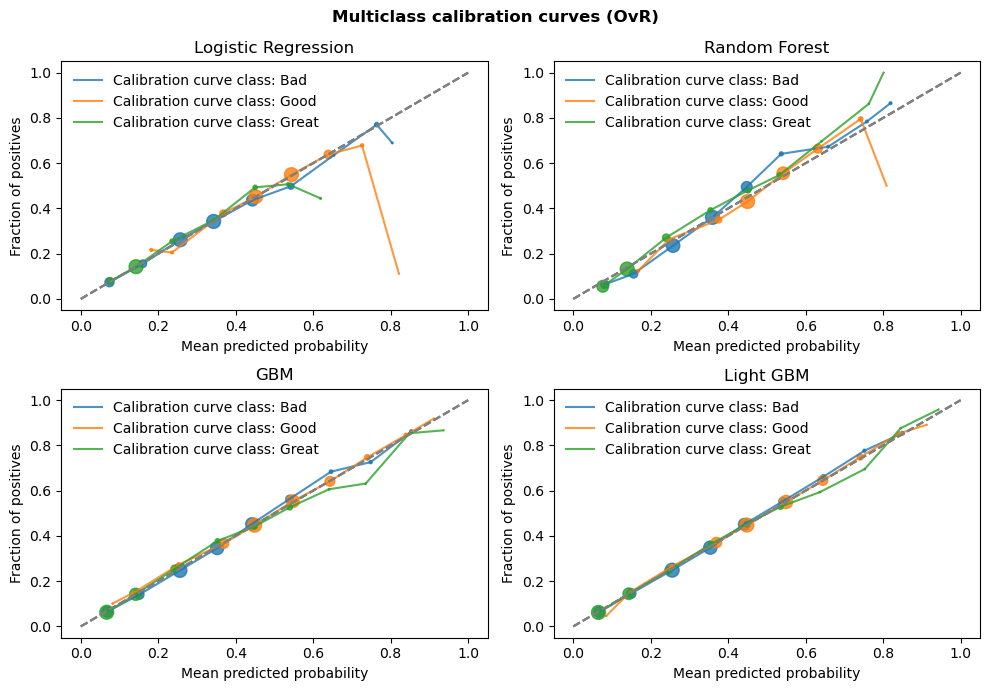

In [109]:
#plt.style.use('dark_background')
classes = {'Bad': 0, 'Good': 1, 'Great': 2}
f, ax = plt.subplots(2,2, figsize=(10,7), dpi=100)


for class_name, class_ in classes.items():
    plot_calibration_curve(ytest.apply(lambda x : 1 if x == class_ else 0), 
                            y_pred_lr[:, class_],
                            ax = ax[0,0], 
                            legend = f'Calibration curve class: {class_name}')
ax[0,0].set_title('Logistic Regression')
    
for class_name, class_ in classes.items():
    plot_calibration_curve(ytest.apply(lambda x : 1 if x == class_ else 0), 
                            y_pred_rf[:, class_],
                            ax = ax[0,1], 
                            legend = f'Calibration curve class: {class_name}')
ax[0,1].set_title('Random Forest')
    
for class_name, class_ in classes.items():
    plot_calibration_curve(ytest.apply(lambda x : 1 if x == class_ else 0), 
                            y_pred_gbm[:, class_],
                            ax = ax[1,0], 
                            legend = f'Calibration curve class: {class_name}')
ax[1,0].set_title('GBM')

for class_name, class_ in classes.items():
    plot_calibration_curve(ytest.apply(lambda x : 1 if x == class_ else 0), 
                            y_pred_lgbm[:, class_],
                            ax = ax[1,1], 
                            legend = f'Calibration curve class: {class_name}')
ax[1,1].set_title('Light GBM')

f.suptitle('Multiclass calibration curves (OvR)',  weight='bold')
f.tight_layout()
plt.show()

## Explainability and SHAP values

SHAP values (SHapley Additive exPlanations) is a method based on cooperative game theory and used to increase transparency and interpretability of machine learning models.

Important: while SHAP shows the contribution or the importance of each feature on the prediction of the model, it does not evaluate the quality of the prediction itself.

In [112]:
import shap 

In [114]:
# Fits the explainer
explainer = shap.Explainer(method.predict, xtest)

In [115]:
# Calculates the SHAP values - It takes some time
shap_values = explainer(xtest)

Permutation explainer: 74122it [44:10, 27.92it/s]                            


**Evaluating the global effect of values**

Here the features are ordered from the highest to the lowest effect on the prediction. It takes in account the absolute SHAP value, so it does not matter if the feature affects the prediction in a positive or negative way.

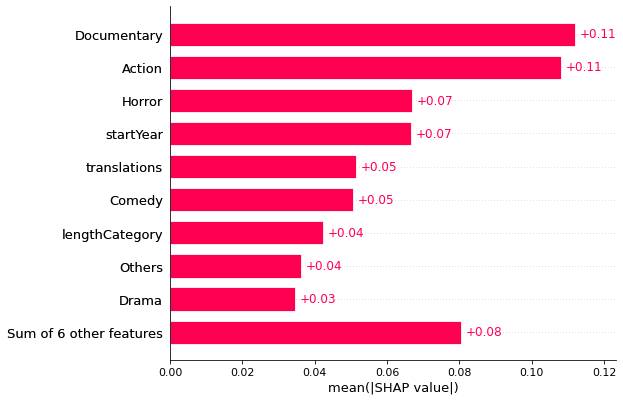

In [116]:
shap.plots.bar(shap_values)

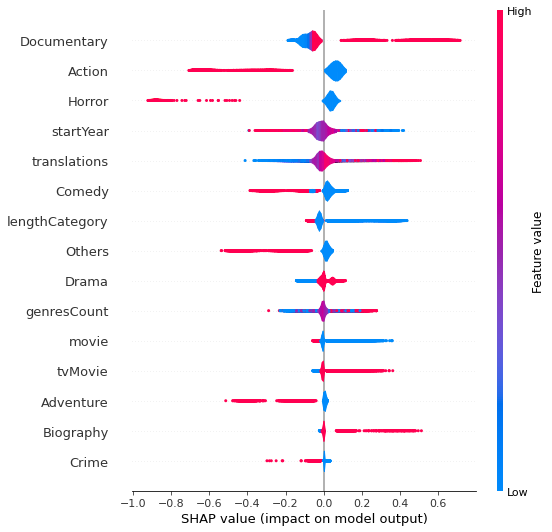

In [118]:
shap.summary_plot(shap_values, plot_type='violin')

**Evaluating local effects**

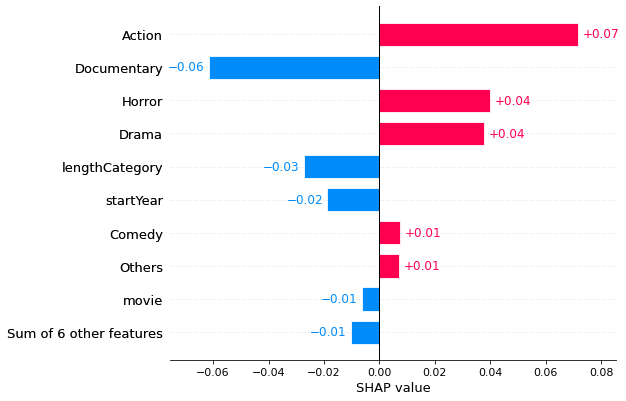

In [119]:
shap.plots.bar(shap_values[0])

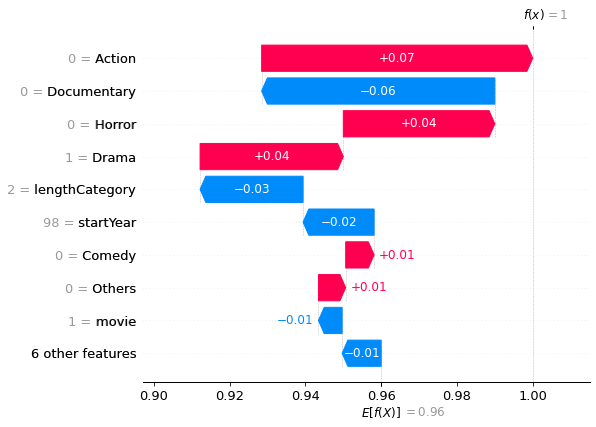

In [120]:
shap.plots.waterfall(shap_values[0])

In [122]:
shap.plots.force(shap_values[0])

In [125]:
#Fitting for the 4 methods tested
methods = [method, method2, method3, method4]

explainer = [shap.Explainer(X.predict, xtest) for X in methods]

In [126]:
# Calculates the SHAP values - It takes some time
shap_values_lr = explainer[0](xtest)

Permutation explainer: 74122it [45:58, 26.76it/s]                             


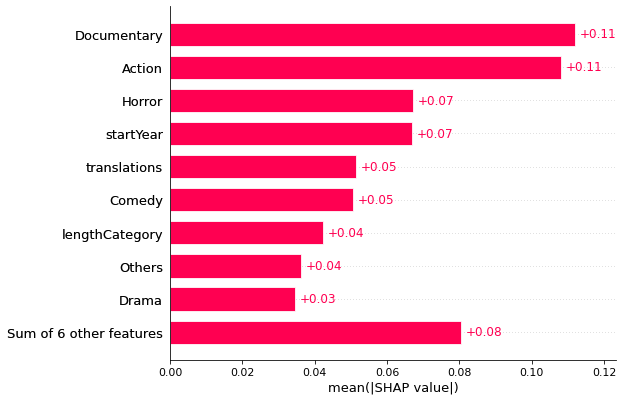

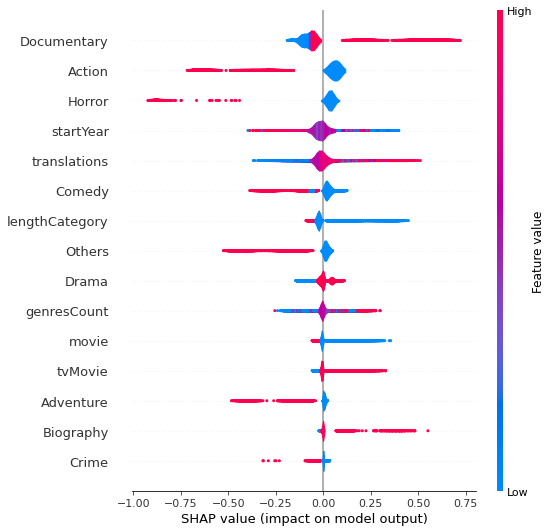

In [134]:
shap.plots.bar(shap_values_lr)
shap.summary_plot(shap_values_lr, plot_type='violin')

In [127]:
shap_values_rf = explainer[1](xtest)

Permutation explainer: 74122it [6:18:12,  3.26it/s]                             


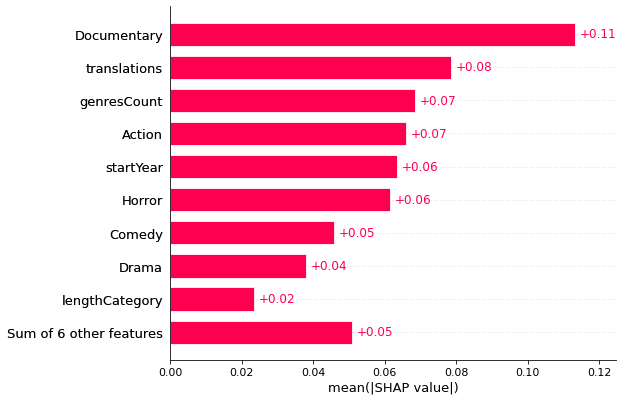

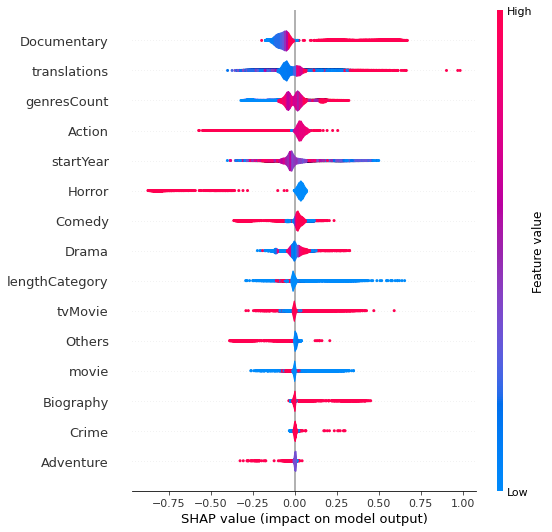

In [135]:
shap.plots.bar(shap_values_rf)
shap.summary_plot(shap_values_rf, plot_type='violin')

In [128]:
shap_values_gbm = explainer[2](xtest)

Permutation explainer: 74122it [2:06:06,  9.78it/s]                             


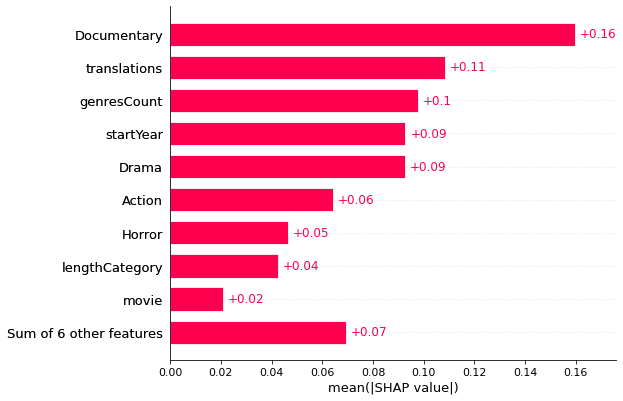

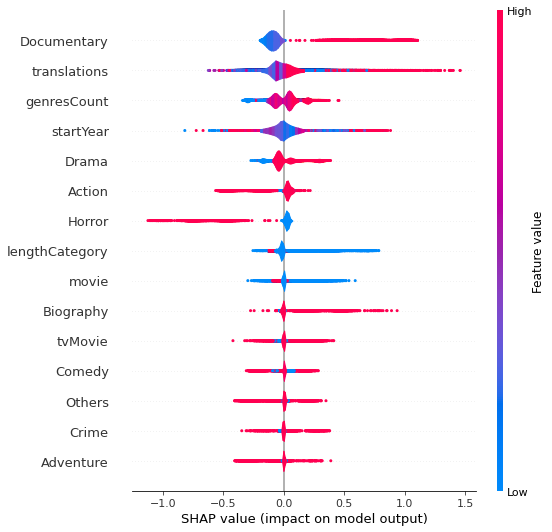

In [136]:
shap.plots.bar(shap_values_gbm)
shap.summary_plot(shap_values_gbm, plot_type='violin')

In [129]:
shap_values_lgbm = explainer[3](xtest)

Permutation explainer: 74122it [2:34:29,  7.99it/s]                             


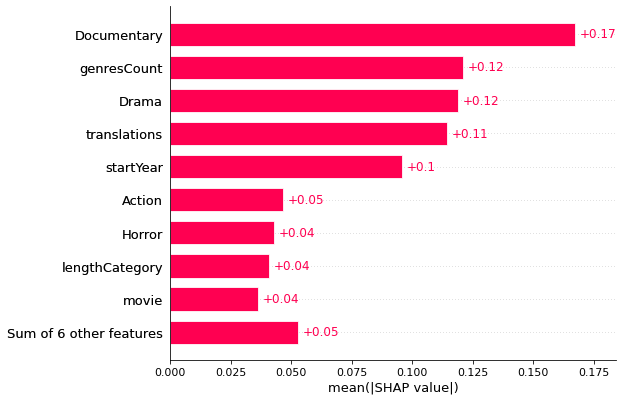

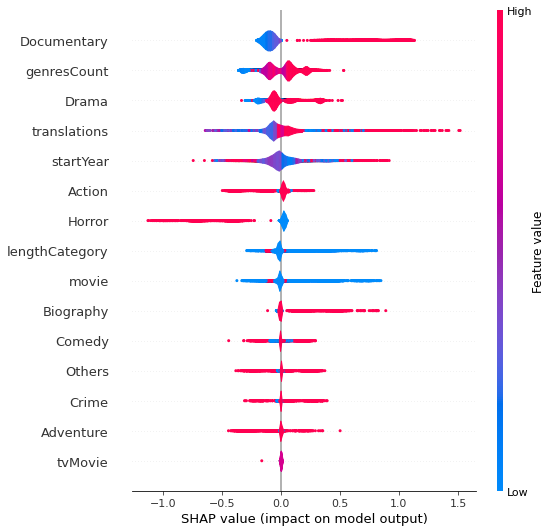

In [137]:
shap.plots.bar(shap_values_lgbm)
shap.summary_plot(shap_values_lgbm, plot_type='violin')

In [168]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
        
    # Calculates the normalized version
    importances_norm = softmax(importances)
    
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    
    # Prints the feature importances
    #for k, v in feature_importances.items():
     #   print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")
    return feature_importances_norm

In [165]:
features_lgbm = print_feature_importances_shap_values(shap_values_lgbm, xtest.columns)

In [166]:
features_lgbm

{'Documentary': 0.07442082066543232,
 'genresCount': 0.07105563012490572,
 'Drama': 0.07090873611374829,
 'translations': 0.07060143086509592,
 'startYear': 0.06928585135894337,
 'Action': 0.0659831203665811,
 'Horror': 0.06571682677811877,
 'lengthCategory': 0.06560000443991926,
 'movie': 0.0652998423729988,
 'Biography': 0.06403262165791,
 'Comedy': 0.06378345043982829,
 'Others': 0.0635373586021781,
 'Crime': 0.06348901314307862,
 'Adventure': 0.06331985407718461,
 'tvMovie': 0.06296543899407667}

In [148]:
features_gbm = [print_feature_importances_shap_values(shap_values_gbm, xtest.columns)]

Documentary -> 0.1596 (softmax = 0.0741)
translations -> 0.1082 (softmax = 0.0704)
genresCount -> 0.0977 (softmax = 0.0696)
startYear -> 0.0928 (softmax = 0.0693)
Drama -> 0.0926 (softmax = 0.0693)
Action -> 0.0642 (softmax = 0.0674)
Horror -> 0.0466 (softmax = 0.0662)
lengthCategory -> 0.0424 (softmax = 0.0659)
movie -> 0.0208 (softmax = 0.0645)
Biography -> 0.0162 (softmax = 0.0642)
tvMovie -> 0.0158 (softmax = 0.0642)
Comedy -> 0.0129 (softmax = 0.0640)
Others -> 0.0107 (softmax = 0.0638)
Crime -> 0.0086 (softmax = 0.0637)
Adventure -> 0.0053 (softmax = 0.0635)


In [146]:
len(features_lgbm)

1

In [147]:
features_lgbm[0]